In [99]:


import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager

from core.fs import FsLoader
from core.repository.maria.conn import maria_home
from utils.timeutil import YearMonth

# 월 차트 로드
print("Fetching month chart...")

begin = YearMonth(2001, 4)
end = YearMonth(2023, 9)

month_chart = pd.read_sql(
    f"""
    select month_chart.*, stocks.stock_name as name from month_chart
    join stocks on month_chart.code = stocks.stock_code
    """,
    maria_home()
)

print("Loading financial data...")
fs_loader = FsLoader()

# matplot 셋업
font_path = './res/font/Gothic_A1/GothicA1-Medium.ttf'
font_manager.fontManager.addfont(font_path)
font_name = font_manager.fontManager.ttflist[-1].name

plt.rc("font", family=font_name)
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10_000

Fetching month chart...
Loading financial data...


In [100]:
import pandas as pd
from utils.timeutil import YearMonth, YearQtr

month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
layer1 = pd.DataFrame()
yms = list(begin.to(end))
# yms = pd.Series([ym for ym in yms if ym.month in [3, 5, 8, 11]] + [max(yms)])
yms = pd.Series(yms)
yms = yms.drop_duplicates().sort_values()

for ym1, ym2 in [(ym.iloc[0], ym.iloc[1]) for ym in yms.rolling(2) if len(ym) == 2]:
    print(f"\r{ym1} {ym2}", end="\r")
    df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
    df2 = month_chart[month_chart["년월"] == ym2].set_index("code")
    df1 = df1[df1["val_last"] >= 1000_0000]
    df2.loc[df2["val_last"] == 0, "close"] = round(df2[df2["val_last"] == 0]["close"] / 2)

    df = pd.DataFrame({
        "종목명": df1["name"],
        "매수년월": ym1, "매도년월": ym2,
        "매수일": df1["date"], "매수가": df1["close"],
        "시가총액": df1["cap"], "거래량": df1["vol"], "거래대금": df1["val"],
        "전월수익률": df1["close"] / df1["open"] - 1
    })

    shares = pd.concat([df1["shares"], df2["shares"]], axis=1)
    df = df.loc[shares.max(axis=1) / shares.min(axis=1) < 1.5]  # 액면분할 제거

    df["매도가"] = df2["close"]
    df["매도일"] = df2["date"]
    df["수익률"] = df["매도가"] / df["매수가"] - 1
    # 재무데이터 조인하여 layer1에 반영
    # due_date로 조회
    settled_qtr = YearQtr.settled_of(ym1.last_date)
    fn = fs_loader.load(settled_qtr.year, settled_qtr.qtr)
    layer1 = pd.concat([layer1, df.join(fn)])

layer1.reset_index(inplace=True)
layer1

,code,종목명,매수년월,매도년월,매수일,매수가,시가총액,거래량,거래대금,전월수익률,...,O_QoQ,E_QoQ,R/A_QoQ,R/EQ_QoQ,GP/A_QoQ,GP/EQ_QoQ,O/A_QoQ,O/EQ_QoQ,E/A_QoQ,E/EQ_QoQ
0,001810,무림SP,2001-04,2001-05,2001-04-30,6010,12095125000,3784523,21538057370,0.073214,...,-0.626848,-0.435061,-0.149304,-0.388128,-0.033125,-0.085528,-0.024073,-0.061906,-0.002947,-0.007671
1,015750,성우하이텍,2001-04,2001-05,2001-04-30,3850,92400000000,16535937,57726582110,0.103152,...,0.454152,0.199793,0.059015,1.634120,0.002684,0.158290,-0.002942,0.057029,-0.008177,0.012367
2,005710,대원산업,2001-04,2001-05,2001-04-30,9070,10884000000,1355734,13792653490,0.146650,...,-0.497916,-0.554240,-1.236995,-10.754597,-0.086390,-0.703816,-0.034968,-0.311177,-0.014239,-0.119304
3,000490,대동,2001-04,2001-05,2001-04-30,5420,25721379640,748120,4062343900,0.026515,...,-0.354726,-0.185016,0.016786,-0.046461,0.033025,0.044650,-0.024053,-0.050730,-0.004515,-0.010658
4,001820,삼화콘덴서공업,2001-04,2001-05,2001-04-30,2715,28222425000,1427430,3807074600,-0.023381,...,-1.538530,-1.480393,-1.025257,-2.192967,-0.183542,-0.404057,-0.092504,-0.209872,-0.058703,-0.132880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391551,054620,APS,2023-08,2023-09,2023-08-31,8380,170903571980,13621792,144890897040,-0.017585,...,-0.551015,-0.342353,0.004770,0.005569,-0.002981,-0.006491,-0.005834,-0.008222,-0.006268,-0.012965
391552,238500,로보쓰리에이아이앤로보틱스,2023-08,2023-09,2023-08-31,626,13468492038,2195548,1282530709,0.026230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391553,154040,다산솔루에타,2023-08,2023-09,2023-08-31,2180,39131204920,21401200,48615828270,-0.022422,...,-0.482587,-2.570269,0.014261,-0.139007,-0.004565,-0.051235,-0.004727,-0.024088,-0.061438,-0.233662
391554,424980,마이크로투나노,2023-08,2023-09,2023-08-31,18700,110683243000,1694084,31405080650,-0.062187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
import numpy as np

layer2 = layer1.rename(
    columns={
        "시가총액": "P",
        "거래대금": "TV",
    }
)

factors = [col for col in layer1.columns if "QoQ" in col and "QoQA" not in col]
factors += [
    "P",
    "EQ/P", "R/P", "GP/P", "O/P", "E/P",
    "R/A", "GP/A", "O/A", "E/A",
    "R/EQ", "GP/EQ", "O/EQ", "E/EQ",
    "배당성향", "배당수익률"
]

layer2["EQ/P"] = layer2["EQ"] / layer2["P"]
layer2["R/P"] = layer2["R/Y"] / layer2["P"]
layer2["GP/P"] = layer2["GP/Y"] / layer2["P"]
layer2["O/P"] = layer2["O/Y"] / layer2["P"]
layer2["E/P"] = layer2["E/Y"] / layer2["P"]

layer2["R/A"] = layer2["R/Y"] / layer2["A"]
layer2["GP/A"] = layer2["GP/Y"] / layer2["A"]
layer2["O/A"] = layer2["O/Y"] / layer2["A"]
layer2["E/A"] = layer2["E/Y"] / layer2["A"]

layer2["R/EQ"] = layer2["R/Y"] / layer2["EQ"]
layer2["GP/EQ"] = layer2["GP/Y"] / layer2["EQ"]
layer2["O/EQ"] = layer2["O/Y"] / layer2["EQ"]
layer2["E/EQ"] = layer2["E/Y"] / layer2["EQ"]

layer2["배당수익률"] = layer2["배당금지급/Y"] / layer2["P"]
layer2["배당성향"] = layer2["배당금지급/Y"] / layer2["E/Y"]

recipes = {
    "벨류": {
        "EQ/P": 1,
        "GP/P": 1
    },
    "성장": {
        "GP/A_QoQ": 0.142706,
        "O/A_QoQ": 0.130182,
        "GP/EQ_QoQ": 0.129825,
        "O/EQ_QoQ": 0.118514,
        "E/EQ_QoQ": 0.111300,
        "O_QoQ": 0.098340,
        "E_QoQ": 0.097314,
        "GP_QoQ": 0.083276,
        "R/A_QoQ": 0.082624,
        "E/A_QoQ": 0.079270,
        "R/EQ_QoQ": 0.028347,
        "R_QoQ": 0.022196,
    },
    "전략": {
        "P": -1,
        "벨류": 1,
        "성장": 1,
    },
    "전략2": {
        "P": -1,
        "벨류": 1,
        "성장": 1,
        "배당수익률": 1
    }
}

result = pd.DataFrame()
yms = layer2["매도년월"].drop_duplicates().sort_values()
for ym in yms:
    print(f"\r{ym}", end="")
    df = layer2[layer2["매도년월"] == ym].copy()
    for factor in factors:
        df[f"{factor}_pct"] = np.ceil(df[factor].dropna().rank(method="min", pct=True) * 100)

    for title, recipe in recipes.items():
        # 1. 레시피를 구성하는 개별 팩터 분위(percentile) * 가중치의 총합을 구함
        sv = sum([df[f"{k}_pct"] * w if w > 0 else -df[f"{k}_pct"] * abs(w) for k, w in recipe.items()])

        # 2. 위의 시리즈에 가중치의 총합을 나눈다 => 0~1 사이 값으로 일반화됨
        df[title] = sv / sum([abs(w) for w in recipe.values()])
        df[f"{title}_pct"] = np.ceil(df[title].rank(method="min", pct=True) * 100)

    result = pd.concat([result, df])

result

2023-09

,code,종목명,매수년월,매도년월,매수일,매수가,P,거래량,TV,전월수익률,...,배당성향_pct,배당수익률_pct,벨류,벨류_pct,성장,성장_pct,전략,전략_pct,전략2,전략2_pct
0,001810,무림SP,2001-04,2001-05,2001-04-30,6010,12095125000,3784523,21538057370,0.073214,...,89.0,91.0,84.0,88.0,63.530983,69.0,48.333333,96.0,59.00,99.0
1,015750,성우하이텍,2001-04,2001-05,2001-04-30,3850,92400000000,16535937,57726582110,0.103152,...,59.0,51.0,23.5,19.0,83.620873,91.0,9.333333,35.0,19.75,40.0
2,005710,대원산업,2001-04,2001-05,2001-04-30,9070,10884000000,1355734,13792653490,0.146650,...,7.0,1.0,68.0,71.0,37.989552,34.0,31.666667,78.0,24.00,49.0
3,000490,대동,2001-04,2001-05,2001-04-30,5420,25721379640,748120,4062343900,0.026515,...,82.0,96.0,93.5,96.0,73.422788,82.0,45.666667,94.0,58.25,98.0
4,001820,삼화콘덴서공업,2001-04,2001-05,2001-04-30,2715,28222425000,1427430,3807074600,-0.023381,...,73.0,70.0,50.5,51.0,20.713275,10.0,5.000000,25.0,21.25,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391551,054620,APS,2023-08,2023-09,2023-08-31,8380,170903571980,13621792,144890897040,-0.017585,...,10.0,1.0,45.5,44.0,44.502637,43.0,10.333333,34.0,8.00,21.0
391552,238500,로보쓰리에이아이앤로보틱스,2023-08,2023-09,2023-08-31,626,13468492038,2195548,1282530709,0.026230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391553,154040,다산솔루에타,2023-08,2023-09,2023-08-31,2180,39131204920,21401200,48615828270,-0.022422,...,10.0,1.0,73.0,77.0,29.135424,23.0,31.000000,78.0,23.50,49.0
391554,424980,마이크로투나노,2023-08,2023-09,2023-08-31,18700,110683243000,1694084,31405080650,-0.062187,...,10.0,1.0,23.5,19.0,NaN,NaN,NaN,NaN,NaN,NaN


[4/4] 전략22001-04 2023-09
            벨류        성장   전략  전략2
EQ/P       1.0       NaN  NaN  NaN
GP/P       1.0       NaN  NaN  NaN
GP/A_QoQ   NaN  0.142706  NaN  NaN
O/A_QoQ    NaN  0.130182  NaN  NaN
GP/EQ_QoQ  NaN  0.129825  NaN  NaN
O/EQ_QoQ   NaN  0.118514  NaN  NaN
E/EQ_QoQ   NaN  0.111300  NaN  NaN
O_QoQ      NaN  0.098340  NaN  NaN
E_QoQ      NaN  0.097314  NaN  NaN
GP_QoQ     NaN  0.083276  NaN  NaN
R/A_QoQ    NaN  0.082624  NaN  NaN
E/A_QoQ    NaN  0.079270  NaN  NaN
R/EQ_QoQ   NaN  0.028347  NaN  NaN
R_QoQ      NaN  0.022196  NaN  NaN
P          NaN       NaN -1.0 -1.0
벨류         NaN       NaN  1.0  1.0
성장         NaN       NaN  1.0  1.0
배당수익률      NaN       NaN  NaN  1.0


,spearman,kendall,h3,h5,h10,t3,t5,t10,mdd5,h3-t3,h10-t10,h3-t3+mdd3,h10-t10+mdd10,mean,median,strength
전략,0.949379,0.816970,0.490573,0.466522,0.413570,-0.153845,-0.146639,-0.120359,-0.474626,0.644418,0.533929,0.153477,0.053253,0.103644,0.090777,0.414123
전략2,0.943258,0.805657,0.410803,0.390425,0.333329,-0.197488,-0.179737,-0.132127,-0.496635,0.608291,0.465455,0.117830,-0.027596,0.100051,0.111864,0.353719
벨류,0.952883,0.817778,0.325874,0.297929,0.273780,-0.237588,-0.212631,-0.154076,-0.523530,0.563462,0.427856,0.021633,-0.119133,0.090865,0.112122,0.333405
성장,0.900966,0.728889,0.233120,0.243011,0.231719,-0.091062,-0.068320,-0.046492,-0.565487,0.324183,0.278210,-0.251280,-0.290395,0.096921,0.097502,0.182702


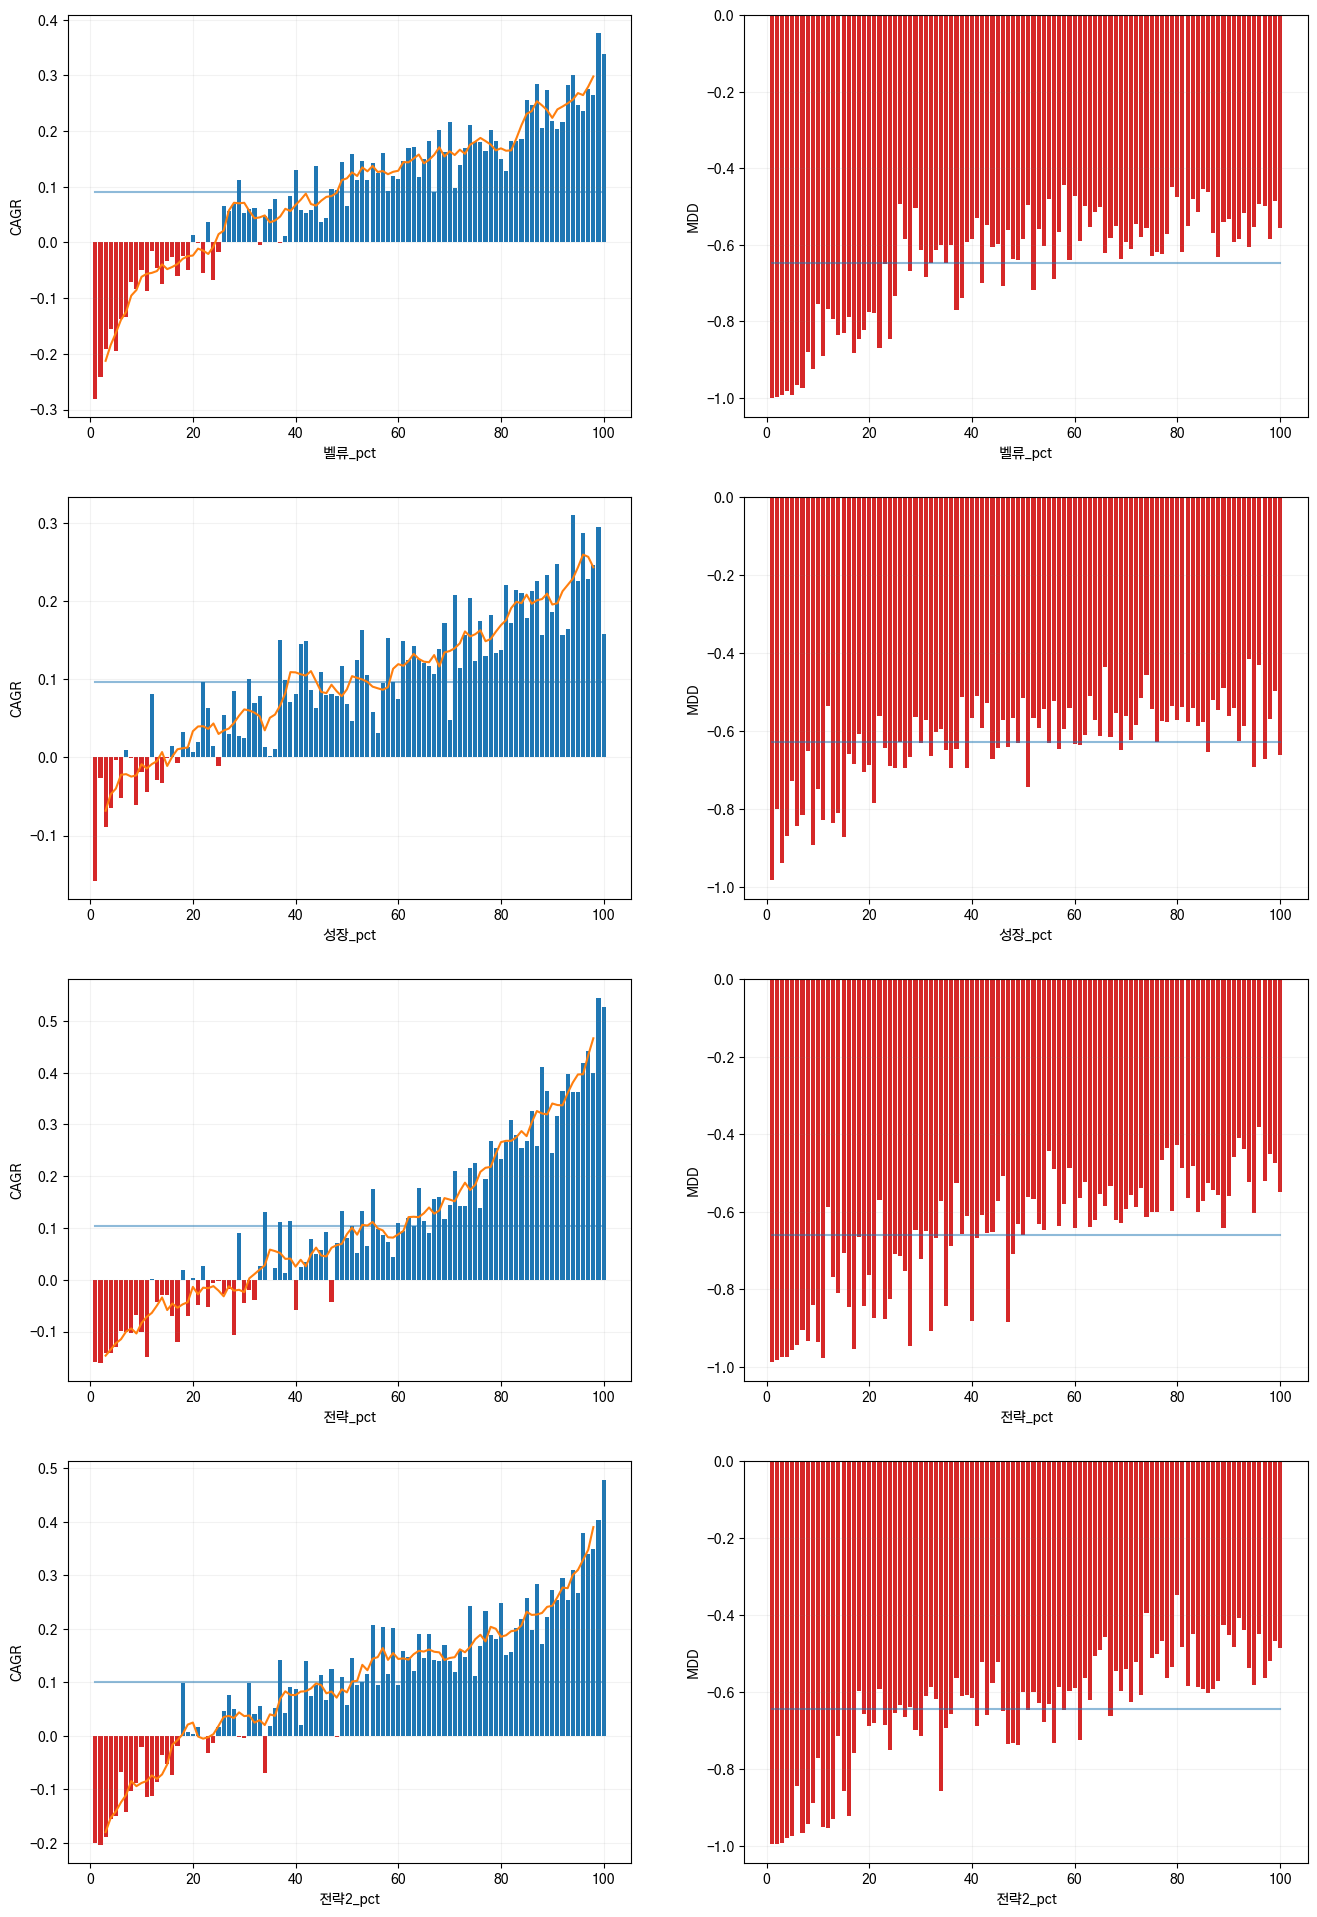

In [102]:
import matplotlib.pyplot as plt
from core.base.quantutil import cagr, mdd

target_factors = list(recipes.keys())
fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(16), fig.set_figheight(6 * len(target_factors))
summary = pd.DataFrame()
for i in range(len(target_factors)):
    factor = target_factors[i]
    print(f"\r[{i + 1}/{len(target_factors)}] {factor}", end="")
    colname = f"{factor}_pct"
    pcts = result[colname].dropna().sort_values().unique()
    mean_by_pct = []
    cagr_by_pct = []
    mdd_by_pct = []
    for pct in pcts:
        by_pct = result[result[colname] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        cumprod = (return_by_ym + 1).cumprod()
        mean_by_pct.append(return_by_ym.mean())
        cagr_by_pct.append(cagr(1, cumprod.iloc[-1], by_pct["매수년월"].min().duration(by_pct["매도년월"].max())))
        dates = [s.last_date for s in return_by_ym.index]
        mdd_by_pct.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]
    cagr_by_pct, mdd_by_pct = pd.Series(cagr_by_pct), pd.Series(mdd_by_pct)

    ax1.set_xlabel(colname)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(pd.Series(pcts), cagr_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_pct])
    ax1.plot(pd.Series(pcts), [cagr_by_pct.mean() for _ in pd.Series(pcts)], alpha=0.5)
    ax1.plot(pd.Series(pcts), cagr_by_pct.rolling(5, center=True).mean())

    ax2.set_xlabel(colname)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(pd.Series(pcts), mdd_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_pct])
    ax2.plot(pd.Series(pcts), [mdd_by_pct.mean() for _ in pd.Series(pcts)], alpha=0.5)

    spearman = pd.DataFrame({colname: pcts, "CAGR": cagr_by_pct}).corr(method="spearman")
    kendall = pd.DataFrame({colname: pcts, "CAGR": cagr_by_pct}).corr(method="kendall")
    cagr_by_pct_desc = cagr_by_pct[cagr_by_pct.index.sort_values(ascending=False)]
    mdd_by_pct_desc = mdd_by_pct[mdd_by_pct.index.sort_values(ascending=False)]
    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": spearman[colname]["CAGR"],
            "kendall": kendall[colname]["CAGR"],
            "h3": cagr_by_pct_desc.head(3).mean(),
            "h5": cagr_by_pct_desc.head(5).mean(),
            "h10": cagr_by_pct_desc.head(10).mean(),
            "t3": cagr_by_pct_desc.tail(3).mean(),
            "t5": cagr_by_pct_desc.tail(5).mean(),
            "t10": cagr_by_pct_desc.tail(10).mean(),
            "mdd5": mdd_by_pct_desc.head(5).mean(),
            "h3-t3": cagr_by_pct_desc.head(3).mean() - cagr_by_pct_desc.tail(3).mean(),
            "h10-t10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean(),
            "h3-t3+mdd3": cagr_by_pct_desc.head(3).mean() - cagr_by_pct_desc.tail(3).mean() + mdd_by_pct_desc.head(
                3).mean(),
            "h10-t10+mdd10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean() + mdd_by_pct_desc.head(
                10).mean(),
            "mean": cagr_by_pct_desc.mean(),
            "median": cagr_by_pct_desc.median(),
        }).to_frame(factor).T
    ])
    summary["strength"] = summary["spearman"] * summary["kendall"] * summary["h10-t10"]

print(result["매수년월"].min(), result["매도년월"].max())
print(pd.DataFrame(recipes))
summary = summary.sort_values(by="strength", ascending=False)
summary

In [103]:
# 백테스트: 매매 시뮬레이션

from core.base.quantutil import cagr, mdd

_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "전략"
print(factor)

result2 = result.copy()[result[factor].notna()]

result2 = result2[~result2["종목명"].str.endswith("홀딩스")]
result2 = result2[~result2["종목명"].str.endswith("지주")]
result2 = result2[result2["R/A_pct"] > 10]
result2 = result2[result2["GP/A_pct"] > 10]
result2 = result2[result2["O/A_pct"] > 10]
result2 = result2[result2["E/A_pct"] > 10]
result2 = result2[result2["R/EQ_pct"] > 10]
result2 = result2[result2["GP/EQ_pct"] > 10]
result2 = result2[result2["O/EQ_pct"] > 10]
result2 = result2[result2["E/EQ_pct"] > 10]


head = 20
strategy = result2.dropna().groupby(_key).apply(lambda x: x.sort_values(factor, ascending=False).head(head)["수익률"].mean())
strategy = pd.Series(strategy, index=benchmark.index).fillna(0)

revisions = pd.DataFrame({
    "벤치마크 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": round(strategy - benchmark, 2),
    "벤치마크 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod()
})

years = (end.value() - begin.value()) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"].iloc[-1], years), cagr(1, revisions["벤치마크 누적수익률"].iloc[-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions.index], revisions["전략 누적수익률"].tolist()),
            mdd([i2 for _, i2 in revisions.index], revisions["벤치마크 누적수익률"].tolist())],
    "Mean": [revisions["전략 수익률"].mean(), revisions["벤치마크 수익률"].mean()]
}, index=["전략", "벤치마크"])
print(summary)

result3 = result2.groupby(_key).apply(
    lambda x: x.sort_values(factor, ascending=False).head(head).sort_values("수익률", ascending=False))[
    ["code", "종목명", "수익률", "매수일", "매도일", "매수가", "매도가", "전월수익률", "P_pct", "성장_pct", "벨류_pct", f"{factor}_pct"]]
result3.to_csv("result3-2.csv")
result3

전략
          CAGR                                         MDD      Mean
전략    0.574616  (-0.46316218989784963, (2007-09, 2008-10))  0.042363
벤치마크  0.101654    (-0.561244133518982, (2007-07, 2008-10))  0.010584


code     종목명       수익률         매수일         매도일  \
매수년월    매도년월                                                               
2001-04 2001-05 614     010780  아이에스동서  0.951220  2001-04-30  2001-05-31   
                280     002140    고려산업  0.354067  2001-04-30  2001-05-31   
                48      004090  한국석유공업  0.308333  2001-04-30  2001-05-31   
                497     004360      세방  0.219512  2001-04-30  2001-05-31   
                379     013700   까뮤이앤씨  0.197297  2001-04-30  2001-05-31   
...                        ...     ...       ...         ...         ...   
2023-08 2023-09 390872  123700   에스제이엠 -0.089901  2023-08-31  2023-09-27   
                389753  019540    일지테크 -0.099421  2023-08-31  2023-09-27   
                390661  095910   에스에너지 -0.113253  2023-08-31  2023-09-27   
                389253  053060      세동 -0.158392  2023-08-31  2023-09-27   
                391075  106240  파인테크닉스 -0.166586  2023-08-31  2023-09-27   

                          매수가      매도가     전월수익률  P_pct  성장_pct  벨류_pct  \
매수년월    매도년월                                                              
2001-04 2001-05 614      1845   3600.0 -0.082090   10.0    91.0    97.0   
                280      2090   2830.0  0.039801    3.0    66.0    96.0   
                48      12000  15700.0  0.000000    6.0    83.0    83.0   
                497      1640   2000.0 -0.003040   21.0    74.0    99.0   
                379      1850   2215.0  0.121212    7.0    78.0    94.0   
...                       ...      ...       ...    ...     ...     ...   
2023-08 2023-09 390872   4060   3695.0 -0.034483   19.0    88.0    93.0   
                389753   5180   4665.0  0.138462   23.0   100.0    83.0   
                390661   2075   1840.0 -0.065315    8.0    78.0    94.0   
                389253   2115   1780.0 -0.088362    6.0    97.0    73.0   
                391075   2065   1721.0 -0.041763    4.0    80.0    89.0   

                        전략_pct  
매수년월    매도년월                    
2001-04 2001-05 614      100.0  
                280       99.0  
                48        99.0  
                497       98.0  
                379       99.0  
...                        ...  
2023-08 2023-09 390872   100.0  
                389753    99.0  
                390661   100.0  
                389253   100.0  
                391075   100.0  

[5380 rows x 12 columns]

In [104]:
revisions

,,벤치마크 수익률,전략 수익률,성능,벤치마크 누적수익률,전략 누적수익률
매수년월,매도년월,,,,,
2001-04,2001-05,0.115954,0.150146,0.03,1.115954,1.150146
2001-05,2001-06,-0.008781,0.094957,0.10,1.106154,1.259360
2001-06,2001-07,-0.114652,-0.071084,0.04,0.979332,1.169840
2001-07,2001-08,-0.051437,0.060555,0.11,0.928958,1.240680
2001-08,2001-09,-0.137448,-0.119534,0.02,0.801274,1.092376
...,...,...,...,...,...,...
2023-04,2023-05,0.033860,0.027613,-0.01,9.381939,25722.194173
2023-05,2023-06,0.007316,0.014938,0.01,9.450574,26106.424850
2023-06,2023-07,-0.033805,0.026732,0.06,9.131100,26804.305134


전체 개월 수       269.000000
초과수익 개월 수     194.000000
누적 성능        3355.251495
dtype: float64

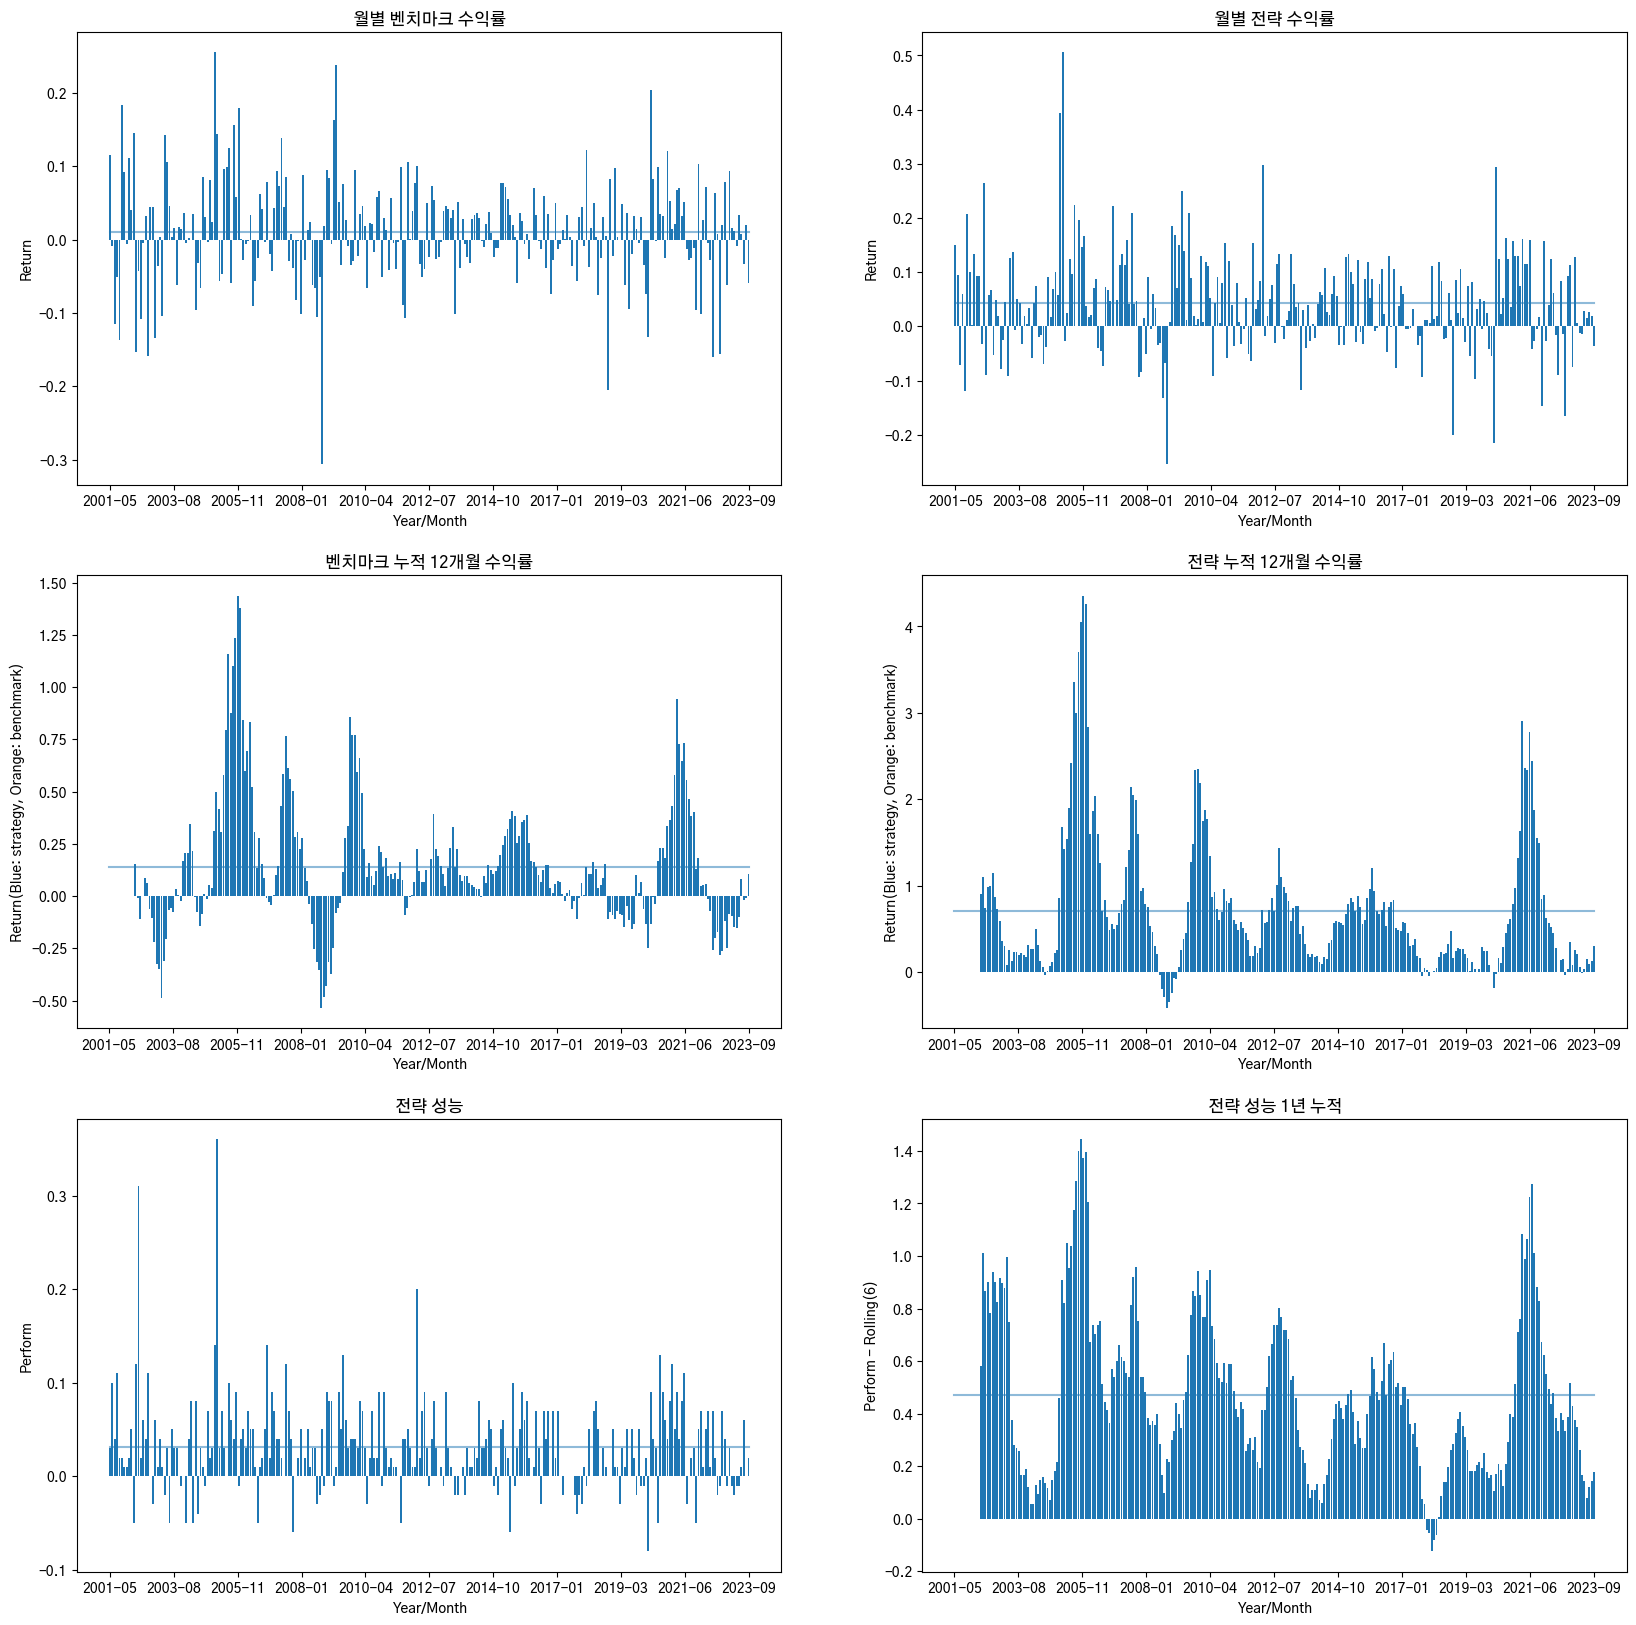

In [105]:
import numpy as np

months = [str(i) for _, i in strategy.index]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"월별 벤치마크 수익률")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["벤치마크 수익률"])
ax1.plot(months, [revisions["벤치마크 수익률"].mean()] * len(months), alpha=0.5)

ax2.set_title("월별 전략 수익률")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["전략 수익률"])
ax2.plot(months, [revisions["전략 수익률"].mean()] * len(months), alpha=0.5)

ax3.set_title(f"벤치마크 누적 12개월 수익률")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["벤치마크 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax3.bar(months, values)
ax3.plot(months, [values.mean()] * len(months), alpha=0.5)

ax4.set_title("전략 누적 12개월 수익률")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["전략 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax4.bar(months, values)
ax4.plot(months, [values.mean()] * len(months), alpha=0.5)

ax5.set_title("전략 성능")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["성능"])
ax5.plot(months, [revisions["성능"].mean()] * len(months), alpha=0.5)

ax6.set_title(f"전략 성능 1년 누적")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({6})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["성능"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax6.bar(months, values)
ax6.plot(months, [values.mean()] * len(months), alpha=0.5)

pd.Series({
    "전체 개월 수": len(revisions),
    "초과수익 개월 수": len(revisions[revisions["성능"] > 0]),
    "누적 성능": (revisions["성능"] + 1).prod() - 1,
})